<a href="https://colab.research.google.com/github/nam07famiVN/skin_cancer_image_classification/blob/main/binary%26multiclass_classification_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline

In [2]:
!pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.svm import SVC

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd /content/drive/MyDrive/IT/CYBERSOFT_MachineDeeplearning/capstone_project

/content/drive/MyDrive/IT/CYBERSOFT_MachineDeeplearning/capstone_project


In [5]:
pwd

'/content/drive/MyDrive/IT/CYBERSOFT_MachineDeeplearning/capstone_project'

In [8]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle_capstone.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Saving kaggle_capstone.json to kaggle_capstone.json
kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
skin-cancer-mnist-ham10000.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IT/CYBERSOFT_MachineDeeplearning/capstone_project/kaggle_capstone.json')
base_dir = '/content/drive/MyDrive/IT/CYBERSOFT_MachineDeeplearning/capstone_project'
csv_path = os.path.join(base_dir, 'data/HAM10000_metadata.csv')
df = pd.read_csv(csv_path)

# Gán nhãn phân loại nhị phân
binary_mapping = {
    'mel': 1, 'bcc': 1, 'akiec': 1, 'vasc': 1, # Label B = 1
    'nv': 0, 'df': 0, 'bkl': 0                # Label M = 0
}
df['label'] = df['dx'].map(binary_mapping)

# 4. Quét toàn bộ ảnh
image_paths = {}
for root, dirs, files in os.walk(base_dir):
    for f in files:
        if f.lower().endswith('.jpg'):
            img_id = os.path.splitext(f)[0]
            image_paths[img_id] = os.path.join(root, f)

print(f"Tổng số ảnh .jpg tìm thấy: {len(image_paths)}")
def extract_features_combined(image_path):
    img = cv2.imread(image_path)
    if img is None: return None

    # 1. Resize ảnh
    img = cv2.resize(img, (64, 64))

    # 2. Đặc trưng Màu sắc: Tính giá trị trung bình và độ lệch chuẩn của 3 kênh màu (R, G, B)
    # Giúp máy nhận diện độ sẫm, độ đỏ
    mean_color = cv2.mean(img)[:3]
    std_color = np.std(img, axis=(0, 1))
    color_feat = np.concatenate([mean_color, std_color]) # Tổng cộng 6 chỉ số màu

    # 3. Đặc trưng HOG (Hình dạng)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_feat = hog(img_gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False)

    # 4. Kết hợp hai loại đặc trưng lại thành 1 vector duy nhất
    combined_feat = np.hstack([hog_feat, color_feat])
    return combined_feat
X = []
y = []

print("Đang trích xuất đặc trưng (có thể mất vài phút)...")
# Lấy 1 phần dữ liệu vừa đủ để train và test
df_sample = df.sample(4000, random_state=42)
for idx, row in df_sample.iterrows():
    img_id = row['image_id']
    if img_id in image_paths:
        feat = extract_features_combined(image_paths[img_id])
        if feat is not None:
            X.append(feat)
            y.append(row['label'])

X = np.array(X)
y = np.array(y)
print(f"Hoàn thành! Kích thước ma trận đặc trưng: {X.shape}")


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
#balance data of 2 classes
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
recall_scorer = make_scorer(recall_score, pos_label=1)
# Định nghĩa các giá trị cần thử nghiệm để lấy bộ tham số tối ưu cho mô hình
param_grid = {
    'C': [1, 10, 50],
    'gamma': [0.001, 0.0001, 'scale']
}
# Khởi tạo mô hình SVM với trọng số ko cân bằng: # Lớp 1 quan trọng gấp 2.5 lần lớp 0
base_svc = SVC(kernel = 'rbf', class_weight={0:1, 1:2.5})
# Thiết lập GridSearchCV
grid = GridSearchCV(base_svc, param_grid,scoring = recall_scorer, refit=True, verbose=2, cv=3, n_jobs=-1)
print("Đang bắt đầu tìm kiếm bộ thông số tối ưu...")
grid.fit(X_train_res, y_train_res)
print(f"Bộ thông số tốt nhất: {grid.best_params_}")
# Dự đoán trên tập test bằng model tốt nhất
grid_predictions = grid.predict(X_test)
# In báo cáo chi tiết
from sklearn.metrics import classification_report, confusion_matrix
print("Độ bao phủ sau khi tối ưu:", recall_score(y_test, grid_predictions))
print(classification_report(y_test, grid_predictions))

LẤY RECALL LÀM METRIC ĐỂ NÂNG CAO XÁC SUẤT DỰ ĐOÁN SỐ CA BỆNH DƯƠNG TÍNH TRÊN TỔNG SỐ CA BỆNH-->NÂNG CAO KHẢ NĂNG PHÁT HIỆN VÀ ĐIỀU TRỊ BỆNH. CÓ THỂ CÓ NHỮNG TRƯỜNG HỢP DƯƠNG TÍNH GIẢ NHƯNG VẪN TỐT HƠN LÀ BỊ BỆNH MÀ KO PHÁT HIỆN ĐƯỢC

"Mô hình ưu tiên chỉ số Recall để đảm bảo an toàn tối đa cho bệnh nhân. Kết quả đạt được giúp phát hiện hơn 92% các trường hợp nguy hiểm, đóng vai trò như một bộ lọc sơ bộ hiệu quả trước khi có sự can thiệp chuyên sâu của bác sĩ chuyên khoa."

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Tính toán điểm tin cậy (decision function) thay vì nhãn 0/1
# SVM dùng decision_function để đo khoảng cách tới ranh giới phân loại
y_score = grid.best_estimator_.decision_function(X_test)

# 2. Tính toán FPR, TPR và ngưỡng
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 3. Vẽ biểu đồ
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Đoán ngẫu nhiên')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tỷ lệ Báo động giả (False Positive Rate)')
plt.ylabel('Tỷ lệ Phát hiện bệnh (True Positive Rate)')
plt.title('Biểu đồ ROC - Mô hình phân loại ung thư da')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
plt.savefig('/content/drive/MyDrive/IT/CYBERSOFT_MachineDeeplearning/capstone_project/binary_roc_curve.png')

In [ ]:
#vẽ heatmap của confusion matrix
cm = confusion_matrix(y_test, grid_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Lành tính (0)', 'Ác tính (1)'],
            yticklabels=['Lành tính (0)', 'Ác tính (1)'])
plt.xlabel('Dự đoán của máy')
plt.ylabel('Thực tế bệnh')
plt.title('Ma trận nhầm lẫn - Chẩn đoán ung thư da')
plt.show()
plt.savefig('/content/drive/MyDrive/IT/CYBERSOFT_MachineDeeplearning/capstone_project/binary_confusion_matrix.png')

In [ ]:
# Lưu model tốt nhất
model_filename = '/content/drive/MyDrive/IT/CYBERSOFT_MachineDeeplearning/capstone_project/binary_svm_skin_cancer.pkl'
joblib.dump(grid.best_estimator_, model_filename)
print(f"Đã lưu mô hình tại: {model_filename}")
# load lại để dùng
# loaded_model = joblib.load('binary_svm_skin_cancer.pkl')

MULTICLASS CLASSIFICATION: hoàn thiện nốt

In [9]:
from sklearn.preprocessing import LabelEncoder
df2 = pd.read_csv('/content/drive/MyDrive/IT/CYBERSOFT_MachineDeeplearning/capstone_project/kaggle_capstone.json')
base_dir = '/content/drive/MyDrive/IT/CYBERSOFT_MachineDeeplearning/capstone_project'
csv_path = os.path.join(base_dir, 'data/HAM10000_metadata.csv')
df2 = pd.read_csv(csv_path)
#gán nhãn
le = LabelEncoder()
df2['label'] = le.fit_transform(df2['dx'])
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('multiclass mapping:', mapping)
print(list(mapping.keys()))
# Quét toàn bộ ảnh
image_paths = {}
for root, dirs, files in os.walk(base_dir):
    for f in files:
        if f.lower().endswith('.jpg'):
            img_id = os.path.splitext(f)[0]
            image_paths[img_id] = os.path.join(root, f)

print(f"Tổng số ảnh .jpg tìm thấy: {len(image_paths)}")
def extract_features_combined(image_path):
    img = cv2.imread(image_path)
    if img is None: return None
    # 1. Resize ảnh
    img = cv2.resize(img, (64, 64))
    # 2. Đặc trưng Màu sắc: Tính giá trị trung bình và độ lệch chuẩn của 3 kênh màu (R, G, B)
    # Giúp máy nhận diện độ sẫm, độ đỏ
    mean_color = cv2.mean(img)[:3]
    std_color = np.std(img, axis=(0, 1))
    color_feat = np.concatenate([mean_color, std_color])
    # 3. Đặc trưng HOG (Hình dạng)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_feat = hog(img_gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False)
    # 4. Kết hợp hai loại đặc trưng lại thành 1 vector duy nhất
    combined_feat = np.hstack([hog_feat, color_feat])
    return combined_feat
X = []
y = []
print("Đang trích xuất đặc trưng (có thể mất vài phút)...")
# Lấy mẫu 4000 ảnh để chạy cho nhanh
df2_sample = df2.sample(4000, random_state=42)
for idx, row in df2_sample.iterrows():
    img_id = row['image_id']
    if img_id in image_paths:
        feat = extract_features_combined(image_paths[img_id])
        if feat is not None:
            X.append(feat)
            y.append(row['label'])
X = np.array(X)
y = np.array(y)
print(f"Hoàn thành! Kích thước ma trận đặc trưng: {X.shape}")

multiclass mapping: {'akiec': np.int64(0), 'bcc': np.int64(1), 'bkl': np.int64(2), 'df': np.int64(3), 'mel': np.int64(4), 'nv': np.int64(5), 'vasc': np.int64(6)}
['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Tổng số ảnh .jpg tìm thấy: 10015
Đang trích xuất đặc trưng (có thể mất vài phút)...
Hoàn thành! Kích thước ma trận đặc trưng: (4000, 1770)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, stratify = y, random_state = 42)
print('số lượng mẫu mỗi lớp của tập train trước SMOTE', np.bincount(y_train))
print('số lượng mẫu mỗi lớp của tập test trước SMOTE', np.bincount(y_test))

số lượng mẫu mỗi lớp của tập train trước SMOTE [  80  126  274   32  273 1589   26]
số lượng mẫu mỗi lớp của tập test trước SMOTE [  53   84  183   22  181 1059   18]


In [15]:
#balance image dataset for 7 classes
strategy_train = {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 6: 1000}
# 1. Tăng các lớp ít dữ liệu lên 1000
over = SMOTE(sampling_strategy=strategy_train, random_state=42)
# 2. Giảm lớp đa số (lớp 5) xuống 1000
under = RandomUnderSampler(sampling_strategy={5: 1000}, random_state=42)
# 3. Kết hợp quy trình
X_train_res, y_train_res = over.fit_resample(X_train, y_train)
X_train_res, y_train_res = under.fit_resample(X_train_res, y_train_res)
#undersample data test để có tỉ lệ dữ liệu các class là giống với data train-->model phân loại tốt hơn
strategy_test = {0: 18, 1: 18, 2: 18, 3: 18, 4: 18, 6: 18} #đưa số dữ liệu ảnh của 7 classes = số dữ liệu ảnh của class ít nhất
under2 = RandomUnderSampler(sampling_strategy=strategy_test, random_state=42)
X_test_res, y_test_res = under2.fit_resample(X_test, y_test)
print("Số lượng mẫu mỗi lớp của tập train sau SMOTE:", np.bincount(y_train_res))
print("Số lượng mẫu mỗi lớp của tập test sau SMOTE:", np.bincount(y_test_res))
# Định nghĩa các giá trị cần thử nghiệm
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale']
}
base_svc = SVC(kernel = 'rbf', class_weight='balanced', decision_function_shape = 'ovr')
# Thiết lập GridSearchCV
f1_macro = make_scorer(f1_score, average='macro')
grid = GridSearchCV(base_svc, param_grid, scoring = f1_macro, refit=True, verbose=2, cv=3, n_jobs=-1)
print("Đang bắt đầu tìm kiếm bộ thông số tối ưu...")
grid.fit(X_train_res, y_train_res)
print(f"Bộ thông số tốt nhất: {grid.best_params_}")
# Dự đoán trên tập test bằng model tốt nhất
grid_predictions = grid.predict(X_test_res)
# In báo cáo chi tiết
print(classification_report(y_test_res, grid_predictions))

Số lượng mẫu mỗi lớp của tập train sau SMOTE: [1000 1000 1000 1000 1000 1000 1000]
Số lượng mẫu mỗi lớp của tập test sau SMOTE: [1000 1000 1000 1000 1000 1000 1000]
Đang bắt đầu tìm kiếm bộ thông số tối ưu...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Bộ thông số tốt nhất: {'C': 100, 'gamma': 'scale'}
              precision    recall  f1-score   support

           0       0.09      0.44      0.15        18
           1       0.09      0.39      0.14        18
           2       0.07      0.50      0.13        18
           3       0.05      0.11      0.07        18
           4       0.06      0.78      0.11        18
           5       0.98      0.52      0.68      1059
           6       0.38      0.67      0.48        18

    accuracy                           0.52      1167
   macro avg       0.24      0.49      0.25      1167
weighted avg       0.90      0.52      0.63      1167



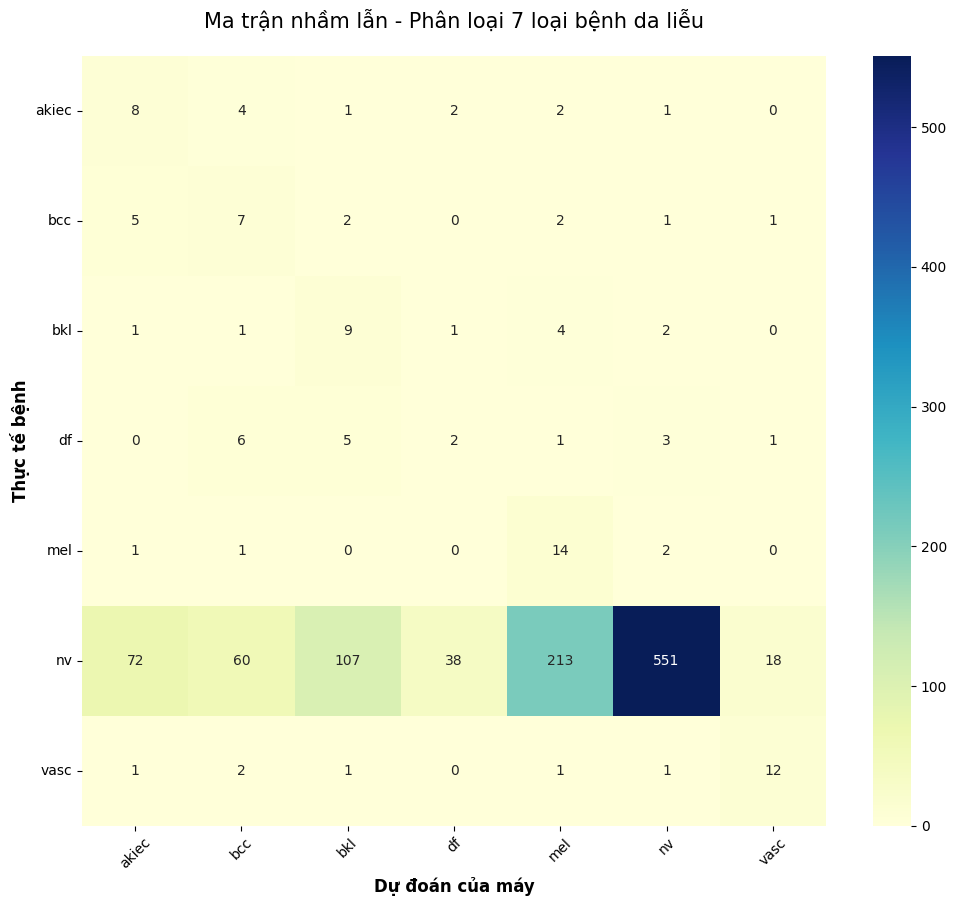

<Figure size 640x480 with 0 Axes>

In [18]:
classes_list = list(mapping.keys())
#hàm vẽ heatmap của confusion matrix
def plot_multiclass_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=labels,
                yticklabels=labels)
    plt.xlabel('Dự đoán của máy', fontsize=12, fontweight='bold')
    plt.ylabel('Thực tế bệnh', fontsize=12, fontweight='bold')
    plt.title('Ma trận nhầm lẫn - Phân loại 7 loại bệnh da liễu', fontsize=15, pad=20)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
    plt.savefig('/content/drive/MyDrive/IT/CYBERSOFT_MachineDeeplearning/capstone_project/MultiClass_confusion_matrix.png')
plot_multiclass_confusion_matrix(y_test_res, grid_predictions, classes_list)

Nhìn chung mô hình phân loại 6 lớp(trừ lớp df) khá tốt. Đối với các ảnh của lớp df(u lành tính), mô hình dự đoán nhầm thành bcc, bkl(u ác tính) nhưng vì ứng dụng của mô hình này là phân loại sơ bộ trước khi đi khám bác sĩ nên tạm thời có thể chấp nhận được

In [19]:
#lưu model tốt nhất
model_filename = '/content/drive/MyDrive/IT/CYBERSOFT_MachineDeeplearning/capstone_project/multiclass_svm_skin_cancer.pkl'
joblib.dump(grid.best_estimator_, model_filename)
print(f"Đã lưu mô hình tại: {model_filename}")

Đã lưu mô hình tại: /content/drive/MyDrive/IT/CYBERSOFT_MachineDeeplearning/capstone_project/multiclass_svm_skin_cancer.pkl
